In [1]:
%load_ext autoreload
%autoreload 2

import requests
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.metrics import mean_squared_error
import pandas as pd
import tqdm
from IPython.display import Image, display
import matplotlib.pyplot as plt

## A. Fetch dataset, split into dev and test

In [2]:
link = "http://lib.stat.cmu.edu/datasets/boston"
raw_text = requests.get(link).text # get the raw text
raw_text = raw_text.split('\n') # split into lines
headers = raw_text[7:21]
headers = [h.split()[0] for h in headers]
raw_text = raw_text[22:-1] # discard description

raw_data = []
for i in range(0, len(raw_text), 2):
    # each row is split into 2 lines, so join them first
    row = raw_text[i] + raw_text[i+1]
    raw_data.append(row)

# split each row into columns and convert each cell -> string to float
raw_data = [[float(column) for column in row.split()] for row in raw_data]
raw_data = np.array(raw_data) # no error => equal length rows, error-free import

In [3]:
# 1/6 parts in test, 5/6 parts in dev for 5-fold cross validation later
# random seed set for reproducibility
raw_dev_data, raw_test_data = train_test_split(raw_data, test_size=1/6, random_state=10)
raw_dev_df = pd.DataFrame(raw_dev_data,columns=headers)

## B. Visualise simple statistics, histograms and diversity

In [4]:
raw_dev_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.00000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000
mean,3.864835,11.178147,11.395606,0.066508,0.556202,6.239606,69.111876,3.80733,9.767221,413.133017,18.554632,353.513088,12.997387,21.804276
std,9.170657,23.555059,6.903976,0.249465,0.116732,0.667412,27.880585,2.13385,8.836772,171.026499,2.136945,95.672303,7.087777,8.662466
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.13700,1.000000,187.000000,12.600000,0.320000,1.920000,5.000000
25%,0.082210,0.000000,5.190000,0.000000,0.449000,5.876000,45.700000,2.06510,4.000000,280.000000,17.400000,374.560000,7.430000,16.500000
50%,0.253870,0.000000,9.900000,0.000000,0.538000,6.167000,77.000000,3.26280,5.000000,334.000000,19.100000,391.270000,11.660000,20.700000
75%,3.849700,12.500000,18.100000,0.000000,0.631000,6.565000,94.500000,5.11800,24.000000,666.000000,20.200000,396.210000,17.210000,24.500000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.12650,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


/home/deepan/anaconda3/envs/das_tempchef/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


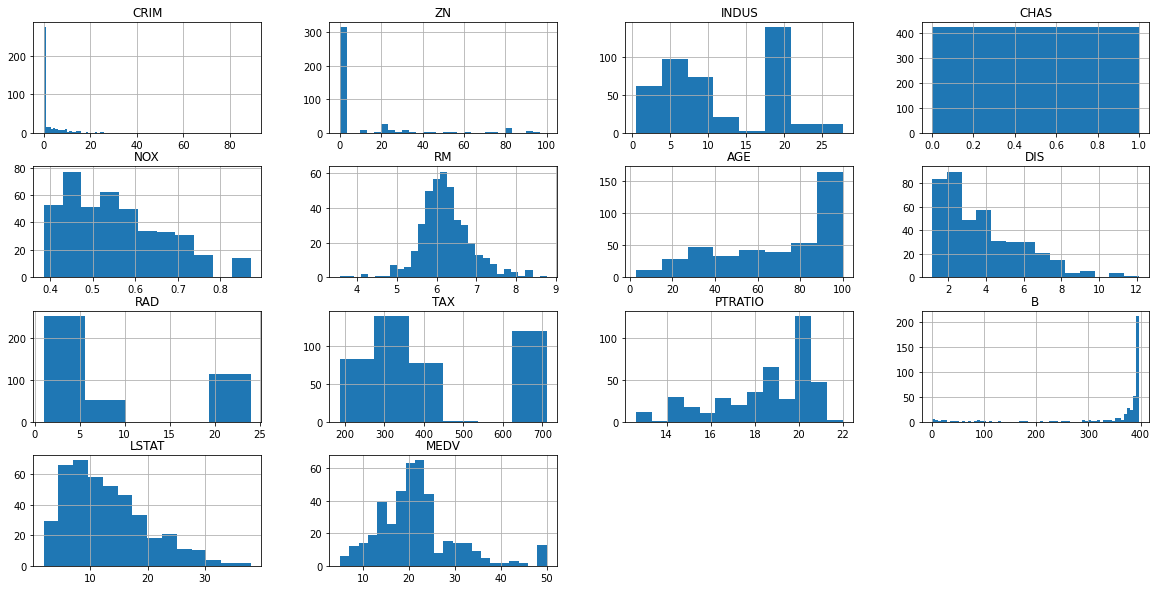

In [5]:
# Freedman Diaconis for bin edges is robust to outliers
# and determines bin numbers/widths according to distribution
hist = raw_dev_df.hist(bins='fd', figsize=(20,10))

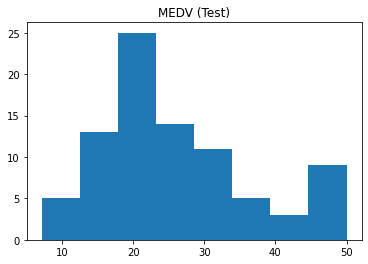

In [6]:
plt.hist(raw_test_data[:,-1],bins='fd'); plt.title('MEDV (Test)'); plt.show()

The distribution of targets in the test set appear similar to the dev distribution.

In [7]:
print('There are <count> unique values in <feature>')
print(len(pd.unique(raw_dev_df['INDUS'])), 'INDUS')
print(len(pd.unique(raw_dev_df['CHAS'])), 'CHAS')
print(len(pd.unique(raw_dev_df['RAD'])), 'RAD')
print(len(pd.unique(raw_dev_df['TAX'])), 'TAX')

print('\n Values in RAD are ', pd.unique(raw_dev_df['RAD']))

There are <count> unique values in <feature>
73 INDUS
2 CHAS
9 RAD
63 TAX

 Values in RAD are  [ 1.  4.  5. 24.  2.  8.  6.  7.  3.]


## C. Visualise correlation matrix

In [8]:
rho_mat = raw_dev_df.corr()
rho_mat.style.background_gradient(vmin=-1, vmax=+1, cmap='coolwarm')

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.000000,-0.196326,0.391956,-0.057702,0.414182,-0.205530,0.351631,-0.379446,0.613703,0.569235,0.279420,-0.372585,0.439895,-0.397463
ZN,-0.196326,1.000000,-0.538815,-0.049833,-0.516129,0.337935,-0.574641,0.661702,-0.308551,-0.318727,-0.402924,0.179437,-0.424803,0.405141
INDUS,0.391956,-0.538815,1.000000,0.063499,0.759945,-0.399829,0.655406,-0.725246,0.585722,0.709278,0.377643,-0.355342,0.611618,-0.501573
CHAS,-0.057702,-0.049833,0.063499,1.000000,0.097407,0.083343,0.096319,-0.102296,-0.001601,-0.029059,-0.113577,0.054563,-0.038427,0.154890
NOX,0.414182,-0.516129,0.759945,0.097407,1.000000,-0.319868,0.734237,-0.774971,0.603406,0.659946,0.182835,-0.381993,0.604911,-0.452804
RM,-0.205530,0.337935,-0.399829,0.083343,-0.319868,1.000000,-0.268796,0.222802,-0.198183,-0.285713,-0.323798,0.095755,-0.592136,0.662315
AGE,0.351631,-0.574641,0.655406,0.096319,0.734237,-0.268796,1.000000,-0.753635,0.452864,0.507927,0.273606,-0.281659,0.635140,-0.415051
DIS,-0.379446,0.661702,-0.725246,-0.102296,-0.774971,0.222802,-0.753635,1.000000,-0.498932,-0.546980,-0.242830,0.298644,-0.519843,0.285068
RAD,0.613703,-0.308551,0.585722,-0.001601,0.603406,-0.198183,0.452864,-0.498932,1.000000,0.908873,0.460533,-0.440416,0.468480,-0.381548
TAX,0.569235,-0.318727,0.709278,-0.029059,0.659946,-0.285713,0.507927,-0.546980,0.908873,1.000000,0.454927,-0.438759,0.531763,-0.471282


## D. Observations

#### Target
$MEDV$ is chosen as the target, as is more popular among projects using this dataset. Since the values are clipped at 50, the targets in the test set can never be OOD (out-of-distribution). The clipping also explains why it deviates from the usual Gaussian distribution in the last bin.

#### Feature vs Target

The correlations are discussed in pages 96-97 (as printed, alternatively pages 16-17 of the pdf viewer) of the dataset paper at
https://deepblue.lib.umich.edu/bitstream/handle/2027.42/22636/0000186.pdf?sequence=1. Those observations are not repeated here. It should be noted that the observed correlations of $DIS$ and $RAD$ with the target differ from the expected correlations.
    
* $RAD$ has only 9 unique values, which do not change smoothly (1,2,..8,24). Explore if transforming to a categorical variable can improve performance. - __Exp 1__
* $ZN$ has most values at exactly 0, while the rest are non-zero. Explore if transforming to binary categorical improves performance. - __Exp 2__
* $CHAS$ is uncorrelated with all other variables as well as the target. However, this poor correlation does not justify dropping the feature. It may have been caused by $CHAS$ being a categorical variable.
* $B$ also has a high skewness and kurtosis in the last bin. Explore if transforming it to a categorical variable improves performance - __Exp 3__
* Non-linear transformations are recommended for $RM$ (-> $RM^2$), $DIS$ (-> $log(DIS)$), $RAD$ (-> $log(RAD)$), $LSTAT$ (-> $log(LSTAT)$) and $B$ (already transformed, $(B'-0.63)^{2}$). Similarly, logarithmic transforms would have been useful to stretch the high density regions of $CRIM$ and $B$ histograms. However, those are required for linear regression. Since we plan to use a Random Forest regressor, these transforms are ignored.

#### Feature vs Feature

* $RAD$ and $TAX$ are highly correlated, while having similar correlations with the target and other variables. $RAD$ can be dropped from the final model - __Exp 4__
* It is simple to explain most correlations. For example, $DIS$ and $NOX$ are highly negatively correlated. This is because pollution levels tend to be higher near highly industrialized parts of a city, where the distance to employment centers would be low.
* Some unexpected correlations can be explained by underlying variables. For example, $TAX$ and $NOX$ are highly correlated, with no obvious cause-effect relationship. But, both those factors are affected by location with respect to highways ($RAD$), which leads to an apparent high correlation.
* Some correlations need additional considerations and further study or domain knowledge before they can be explained. They are beyond the scope of the given data. Such an example is the correlation between $DIS$ and $ZN$.

## E. Experiments

Random Forest regression is used in all experiments.
* It can model non-linear relationships
* It can handle categorical data
* Data does not need to be standardised/normalised
* Target values will not be OOD
* Overfitting can be controlled for easily by changing the number of Decision Trees (as a first experiment, while other hyper-parameters are also available for fine-tuning)

To track and compare the performance across experiments, we will be using the following metrics:
* Mean Square Error (MSE) between predicted and ground truth target values
* Correlation Co-efficient (RHO) between the same, to check if the model is at least learning the trend in the data (ideally this should be $> RHO^{MEDV}_{LSTAT} = 0.746$, which is the maximum correlation coefficient between any feature and the target)

Other implementation details:
* 5-fold cross validation will be used in every experiment
* All hyper-parameters for the Random Forest will be kept constant for now, to enable fair comparison among experiments
* No feature reduction is performed since the number of features is low enough, with respect to the number of samples, to not overfit.


#### Base function to run 5-fold CV for every experiment

In [9]:
def run_folds(df, model=None, verbose=True):
    
    if model is None:
        model = rf(n_estimators=50, random_state=1, n_jobs=5, max_features=0.33)
    # used original recommendation of split_features = max_features / 3
    # instead of all features per split
    
    n_folds = 5
    kf = KFold(n_splits = n_folds, shuffle = True, random_state = 10)
    
    mse_tr_all = []; mse_ev_all = []; rho_tr_all = [];  rho_ev_all = []
    feature_importance_all = np.zeros(df.shape[-1]-1)

    for tr_id, ev_id in kf.split(df): # get fold ids
            
        df_train = df.iloc[tr_id]
        X_train = df_train[df.columns[:-1]].to_numpy(); y_train = df_train[df.columns[-1]].to_numpy()
                
        df_eval = df.iloc[ev_id]
        X_eval = df_eval[df.columns[:-1]].to_numpy(); y_eval = df_eval[df.columns[-1]].to_numpy()
        
        model.fit(X_train,y_train) # training
        y_pred_tr = model.predict(X_train); y_pred_ev = model.predict(X_eval) # evaluation
        
        # Metric 1
        mse_tr = mean_squared_error(y_train, y_pred_tr); mse_tr_all.append(round(mse_tr,3))
        mse_ev = mean_squared_error(y_eval, y_pred_ev); mse_ev_all.append(round(mse_ev,3))
        
        # Metric 2
        rho_tr = np.corrcoef(y_train, y_pred_tr); rho_tr_all.append(round(rho_tr[0,1],3))
        rho_ev = np.corrcoef(y_eval, y_pred_ev); rho_ev_all.append(round(rho_ev[0,1],3))
        
        feature_importance_all += model.feature_importances_
    
    feature_rank = list(np.argsort(feature_importance_all))
    feature_rank.reverse() # rank features by importance
    feature_rank = list(df.columns[feature_rank]) # recover feature name
    performance = {'mse_ev':mse_ev_all, 'mse_tr':mse_tr_all,
                   'rho_ev':rho_ev_all, 'rho_tr':rho_tr_all,
                   'feature_rank':feature_rank}
    
    if verbose:
        print('\nPerformance across 5-fold Cross Validation\n')
        print('MSE Train : ', performance['mse_tr'])
        print('MSE Eval : ', performance['mse_ev'], '\n')
        print('RHO Train : ', performance['rho_tr'])
        print('RHO Eval : ', performance['rho_ev'], '\n')
        print('Features sorted by importance : ', performance['feature_rank'])
    
    return performance, model

## Exp 0

Baseline experiment, where all features are fed as is to a Random Forest regression model

In [10]:
performance_0, model_0 = run_folds(raw_dev_df)


Performance across 5-fold Cross Validation

MSE Train :  [1.538, 1.467, 1.786, 1.479, 1.514]
MSE Eval :  [8.239, 17.267, 4.191, 9.579, 13.477] 

RHO Train :  [0.992, 0.99, 0.99, 0.992, 0.992]
RHO Eval :  [0.935, 0.946, 0.969, 0.924, 0.864] 

Features sorted by importance :  ['LSTAT', 'RM', 'NOX', 'DIS', 'CRIM', 'PTRATIO', 'INDUS', 'AGE', 'TAX', 'B', 'RAD', 'ZN', 'CHAS']


## Exp 1

Convert $RAD$ to categorical

In [11]:
rad_dev_df = raw_dev_df.copy(deep=True)
rad_cat = pd.get_dummies(rad_dev_df['RAD'], prefix='RAD')
rad_dev_df = rad_dev_df.drop('RAD', axis=1)
rad_dev_df = rad_cat.join(rad_dev_df)

performance_1, model_1 = run_folds(rad_dev_df)


Performance across 5-fold Cross Validation

MSE Train :  [1.458, 1.62, 1.889, 1.651, 1.67]
MSE Eval :  [9.167, 16.594, 4.046, 10.074, 15.343] 

RHO Train :  [0.992, 0.99, 0.99, 0.992, 0.991]
RHO Eval :  [0.928, 0.953, 0.971, 0.921, 0.843] 

Features sorted by importance :  ['LSTAT', 'RM', 'CRIM', 'INDUS', 'DIS', 'NOX', 'AGE', 'PTRATIO', 'B', 'TAX', 'ZN', 'CHAS', 'RAD_24.0', 'RAD_4.0', 'RAD_5.0', 'RAD_1.0', 'RAD_3.0', 'RAD_8.0', 'RAD_2.0', 'RAD_7.0', 'RAD_6.0']


There is a signficant drop in performance. Also, the importance of the individual $RAD$ categories has diminished.

## Exp 2

Transform $ZN$ to binary categorical variable

In [12]:
zn_dev_df = raw_dev_df.copy(deep=True)
zn_dev_df['ZN'] = np.sign(zn_dev_df['ZN'])
zn_cat = pd.get_dummies(zn_dev_df['ZN'], prefix='ZN')
zn_dev_df = zn_dev_df.drop('ZN', axis=1)
zn_dev_df = zn_cat.join(zn_dev_df)

performance_2, model_2 = run_folds(zn_dev_df)


Performance across 5-fold Cross Validation

MSE Train :  [1.567, 1.469, 1.882, 1.625, 1.678]
MSE Eval :  [8.342, 16.252, 3.997, 10.299, 16.112] 

RHO Train :  [0.992, 0.99, 0.989, 0.991, 0.991]
RHO Eval :  [0.934, 0.951, 0.971, 0.918, 0.835] 

Features sorted by importance :  ['RM', 'LSTAT', 'NOX', 'CRIM', 'DIS', 'PTRATIO', 'INDUS', 'AGE', 'TAX', 'B', 'RAD', 'CHAS', 'ZN_0.0', 'ZN_1.0']


Performance is slightly worse than Exp 0.

## Exp 3

Convert $B$ to a categorical variable with low and high tiers

In [13]:
b_dev_df = raw_dev_df.copy(deep=True)
b = b_dev_df['B'].copy(deep=True)
b = np.sign(np.sqrt(b/1000) - (0.63-0.37))
# 40% to 85% Black population transforms to negative, anything outside this range is positive
# explicitly models the parabolic dependency of target on B, acts like an indicator
b_cat = pd.get_dummies(b, prefix='B')
b_dev_df = b_dev_df.drop('B', axis=1)
b_dev_df = b_cat.join(b_dev_df)

performance_3, model_3 = run_folds(b_dev_df)


Performance across 5-fold Cross Validation

MSE Train :  [1.468, 1.453, 1.842, 1.573, 1.374]
MSE Eval :  [8.178, 16.555, 4.678, 10.517, 13.636] 

RHO Train :  [0.992, 0.99, 0.989, 0.992, 0.993]
RHO Eval :  [0.937, 0.951, 0.965, 0.918, 0.862] 

Features sorted by importance :  ['LSTAT', 'RM', 'CRIM', 'NOX', 'DIS', 'INDUS', 'PTRATIO', 'AGE', 'TAX', 'ZN', 'RAD', 'CHAS', 'B_1.0', 'B_-1.0']


Slight improvement in performance over Exp 0.

## Exp 4

Drop $RAD$ or $TAX$, since they are highly correlated

In [14]:
drop_dev_df = raw_dev_df.copy(deep=True)
drop_dev_df = drop_dev_df.drop('RAD', axis=1)

performance_4a, model_4a = run_folds(drop_dev_df)

drop_dev_df = raw_dev_df.copy(deep=True)
drop_dev_df = drop_dev_df.drop('TAX', axis=1)

performance_4b, model_4b = run_folds(drop_dev_df)


Performance across 5-fold Cross Validation

MSE Train :  [1.465, 1.589, 1.865, 1.734, 1.597]
MSE Eval :  [8.304, 19.363, 4.883, 10.595, 12.558] 

RHO Train :  [0.992, 0.99, 0.99, 0.992, 0.992]
RHO Eval :  [0.935, 0.944, 0.964, 0.918, 0.874] 

Features sorted by importance :  ['LSTAT', 'RM', 'CRIM', 'NOX', 'PTRATIO', 'DIS', 'TAX', 'INDUS', 'AGE', 'B', 'ZN', 'CHAS']

Performance across 5-fold Cross Validation

MSE Train :  [1.581, 1.57, 1.884, 1.776, 1.59]
MSE Eval :  [8.607, 17.256, 4.364, 10.886, 11.839] 

RHO Train :  [0.992, 0.99, 0.989, 0.991, 0.992]
RHO Eval :  [0.932, 0.949, 0.968, 0.914, 0.882] 

Features sorted by importance :  ['LSTAT', 'RM', 'CRIM', 'NOX', 'PTRATIO', 'DIS', 'INDUS', 'AGE', 'B', 'ZN', 'RAD', 'CHAS']


Dropping $TAX$ provides a greater improvement than dropping $RAD$. This might seem counter-intuitive, since $TAX$ has more unique values and varies smoothly compared to $RAD$. But it might be explained by the fact that the underlying distribution of $TAX$ is based on the bins of $RAD$. This can also be seen in their histograms.

## F. Hyperparameter tuning

Hyper-parameter tuning on Exp 4, by observing 5-fold performance on the eval set over the hyper-parameter search space

/tmp/ipykernel_23180/1993911922.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_mse.set_yticklabels(labels); ax_rho.set_yticklabels(labels)


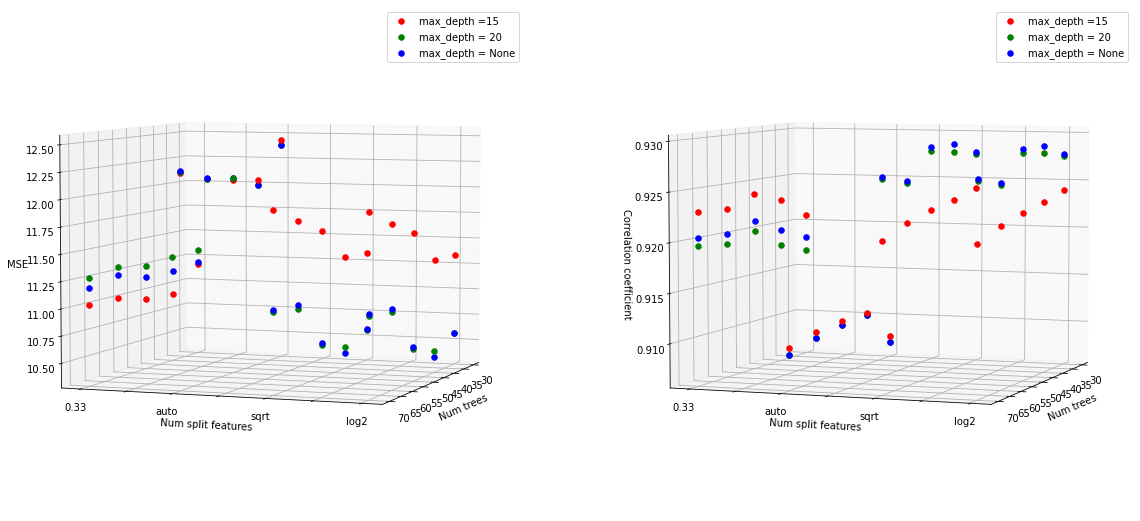

In [15]:
final_dev_df = raw_dev_df.copy(deep=True)
final_dev_df = final_dev_df.drop('TAX', axis=1)

# hparams search space (grid)
num_tree_list = [30, 40, 50, 60, 70]
split_features_list = [1/3, 'auto', 'sqrt', 'log2']
depth_list = [15, 20, None]
color_list = ['r', 'g', 'b']

# init plots
fig = plt.figure(figsize=(20,10))
ax_mse = plt.subplot(121,projection='3d'); ax_mse.set_zlabel('MSE')
ax_mse.set_xlabel('Num trees'); ax_mse.set_ylabel('Num split features')
ax_rho = plt.subplot(122,projection='3d'); ax_rho.set_zlabel('Correlation coefficient')
ax_rho.set_xlabel('Num trees'); ax_rho.set_ylabel('Num split features')
ax_mse.view_init(elev=5, azim=20); ax_rho.view_init(elev=5, azim=20)

# run 5-fold CV on each hparam combo
for num_tree in num_tree_list:
    for k, split_features in enumerate(split_features_list):
        for depth, color in zip(depth_list, color_list):
            
            model = rf(n_estimators=num_tree, max_features=split_features, max_depth=depth,
                       random_state=1, n_jobs=5)
            performance, _ = run_folds(final_dev_df, model, verbose=False)
            
            ax_mse.scatter(num_tree, k, np.mean(performance['mse_ev']), color=color, s=30)
            ax_rho.scatter(num_tree, k, np.mean(performance['rho_ev']), color=color, s=30)

# correct ticks
labels = [item.get_text() for item in ax_mse.get_yticklabels()]
labels[1] = '0.33'; labels[3] = 'auto'; labels[5] = 'sqrt'; labels[7] = 'log2'
ax_mse.set_yticklabels(labels); ax_rho.set_yticklabels(labels)

ax_mse.legend(['max_depth =15', 'max_depth = 20', 'max_depth = None'])
ax_rho.legend(['max_depth =15', 'max_depth = 20', 'max_depth = None'])

Low MSE and high RHO are desired. This is achieved by
* Setting Tree depth to be infinite (practically it turns out to be <25)
* Using 40 Trees to build the Forest
* Considering either sqrt() or log2() of the total number of features at each split
* Ideally, one should also observe which configuration causes the least performance variation among folds. But that would lead to a very cluttered plot. Unless the plot can be rotated interactively, it might lead to the viewer making the wrong conclusion due to incorrect viewing angles.

## G. Test

MSE :  22.04
RHO :  0.917


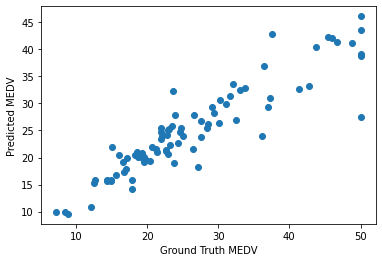

In [16]:
model = rf(n_estimators=40, max_features='sqrt', max_depth=None, random_state=1, n_jobs=5)

# process test set
raw_test_df = pd.DataFrame(raw_test_data,columns=headers)
final_test_df = raw_test_df.drop('TAX', axis=1)

X_dev = final_dev_df[final_dev_df.columns[:-1]].to_numpy()
y_dev = final_dev_df[final_dev_df.columns[-1]].to_numpy()

X_test = final_test_df[final_test_df.columns[:-1]].to_numpy()
y_test = final_test_df[final_test_df.columns[-1]].to_numpy()
        
model.fit(X_dev,y_dev) # training 
y_pred = model.predict(X_test) # testing

mse = round(mean_squared_error(y_test, y_pred),3)
rho = np.corrcoef(y_test, y_pred); rho = round(rho[0,1],3)

plt.scatter(y_test, y_pred)
plt.xlabel('Ground Truth MEDV'); plt.ylabel('Predicted MEDV')

print('MSE : ', mse)
print('RHO : ', rho)

Comments:
* The model performs better on lower prices than on higher prices. This is expected, since the histogram shows that the target distribution deviates from a Gausian at the higher price range.
* A strong linear trend between predicted and ground truth values show that the model has learned the trend in the data, i.e. how it correlates to the input features.
* The agreement in trend is reflected in the high correlation coefficient between ground truth and predictions.
* MSE is higher (worse) than observed during cross validation. This can be explaned by limited data (sub optimal sampling) and by the deviation from a Gaussian distribution.